<a href="https://colab.research.google.com/github/omer-re/will_it_fit/blob/main/will_it_fit_in_elevator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# 📌 Enable inline plotting
%matplotlib inline

# 📌 Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as R
from itertools import product
import ipywidgets as widgets
from IPython.display import display

# 📌 Suppress font glyph warnings (optional)
import warnings

warnings.filterwarnings("ignore")


# 📌 Utility: Draw a 3D box in space
def draw_box(ax, origin, size, color, alpha=0.2, label=None):
    ox, oy, oz = origin
    l, w, h = size
    x = [ox, ox + l]
    y = [oy, oy + w]
    z = [oz, oz + h]

    vertices = [
        [x[0], y[0], z[0]],
        [x[1], y[0], z[0]],
        [x[1], y[1], z[0]],
        [x[0], y[1], z[0]],
        [x[0], y[0], z[1]],
        [x[1], y[0], z[1]],
        [x[1], y[1], z[1]],
        [x[0], y[1], z[1]],
    ]

    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # front
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # back
        [vertices[1], vertices[2], vertices[6], vertices[5]],  # right
        [vertices[3], vertices[0], vertices[4], vertices[7]],  # left
    ]

    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, edgecolors='black', alpha=alpha))

    if label:
        ax.text(ox + l / 2, oy + w / 2, oz + h + 5, label, color='black', ha='center')


# 📌 Check if all rotated corners are inside the elevator volume
def check_fit_in_elevator(corners, elevator_dims):
    corners = np.array(corners)
    return (
            (corners[:, 0] >= 0).all() and (corners[:, 0] <= elevator_dims[0]).all() and
            (corners[:, 1] >= 0).all() and (corners[:, 1] <= elevator_dims[1]).all() and
            (corners[:, 2] >= 0).all() and (corners[:, 2] <= elevator_dims[2]).all()
    )


# 📌 Check if projection of rotated box can pass through door opening (YZ projection)
def check_fit_through_door(rotated_corners, door_dims):
    projection = rotated_corners[:, [1, 2]]  # Project onto Y-Z plane
    min_corner = np.min(projection, axis=0)
    max_corner = np.max(projection, axis=0)
    width_required, height_required = max_corner - min_corner

    door_width, door_height = door_dims
    return width_required <= door_width and height_required <= door_height


# 📌 Main function to test and visualize
def find_valid_fit_with_door_constraint(box_small, box_large, door_dims):
    l, w, h = box_small
    corners = np.array([
        [0, 0, 0],
        [l, 0, 0],
        [l, w, 0],
        [0, w, 0],
        [0, 0, h],
        [l, 0, h],
        [l, w, h],
        [0, w, h]
    ])
    centroid = np.mean(corners, axis=0)
    corners_centered = corners - centroid

    best_fit = None
    # 🔁 Optimization: Use coarse 10° steps for fast testing
    for yaw, pitch, roll in product(range(0, 91, 10), repeat=3):
        rot = R.from_euler('zyx', [yaw, pitch, roll], degrees=True)
        rotated = rot.apply(corners_centered) + np.array(box_large) / 2

        if check_fit_in_elevator(rotated, box_large) and check_fit_through_door(rotated, door_dims):
            best_fit = (rotated, yaw, pitch, roll)
            break

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    draw_box(ax, origin=(0, 0, 0), size=box_large, color='blue', alpha=0.1, label='Elevator')

    if best_fit:
        rotated_corners, yaw, pitch, roll = best_fit
        faces = [
            [0, 1, 2, 3],
            [4, 5, 6, 7],
            [0, 1, 5, 4],
            [2, 3, 7, 6],
            [1, 2, 6, 5],
            [3, 0, 4, 7]
        ]
        sofa_faces = [[rotated_corners[i] for i in face] for face in faces]
        ax.add_collection3d(
            Poly3DCollection(sofa_faces, facecolors='green', edgecolors='black', linewidths=1, alpha=0.5))
        ax.text(*np.mean(rotated_corners, axis=0), f"Yaw={yaw}°, Pitch={pitch}°, Roll={roll}°", color='black',
                ha='center')
        ax.set_title("✅ Valid Fit Through Door and Elevator")
    else:
        ax.set_title("❌ No Fit Found (Including Door Constraints)")

    ax.set_xlabel('Length (X)')
    ax.set_ylabel('Width (Y)')
    ax.set_zlabel('Height (Z)')
    max_range = max(box_large)
    ax.set_xlim(0, max_range)
    ax.set_ylim(0, max_range)
    ax.set_zlim(0, max_range)
    plt.tight_layout()
    plt.show()

    return best_fit is not None


# 📌 UI: Create interactive widgets for user input
sofa_length = widgets.IntSlider(value=270, min=50, max=400, step=5, description='Sofa Length:')
sofa_width = widgets.IntSlider(value=70, min=40, max=200, step=5, description='Sofa Width:')
sofa_height = widgets.IntSlider(value=25, min=5, max=150, step=5, description='Sofa Height:')

elevator_length = widgets.IntSlider(value=238, min=100, max=300, step=5, description='Elevator Len:')
elevator_width = widgets.IntSlider(value=100, min=80, max=200, step=5, description='Elevator Wid:')
elevator_height = widgets.IntSlider(value=215, min=150, max=300, step=5, description='Elevator Hei:')

door_width = widgets.IntSlider(value=100, min=60, max=150, step=5, description='Door Width:')
door_height = widgets.IntSlider(value=215, min=150, max=300, step=5, description='Door Height:')

run_button = widgets.Button(description="Run Fit Check")


# 📌 Callback function
def on_button_click(b):
    sofa = [sofa_length.value, sofa_width.value, sofa_height.value]
    elevator = [elevator_length.value, elevator_width.value, elevator_height.value]
    door = [door_width.value, door_height.value]

    print(f"🛋️ Sofa: {sofa}")
    print(f"🏢 Elevator: {elevator}")
    print(f"🚪 Door: {door}")
    find_valid_fit_with_door_constraint(sofa, elevator, door)


run_button.on_click(on_button_click)

# 📌 Display all widgets
display(
    widgets.VBox([
        widgets.HTML("<h3>📐 Sofa Dimensions</h3>"),
        sofa_length, sofa_width, sofa_height,
        widgets.HTML("<h3>📦 Elevator Interior Dimensions</h3>"),
        elevator_length, elevator_width, elevator_height,
        widgets.HTML("<h3>🚪 Elevator Door Dimensions</h3>"),
        door_width, door_height,
        run_button
    ])
)


SyntaxError: invalid syntax (3493865048.py, line 1)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as R
from itertools import product
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.patheffects as path_effects

# ─── Shared helpers ──────────────────────────────────────────────────────────

def draw_box(ax, origin, size, color, alpha=0.2):
    ox, oy, oz = origin
    l, w, h = size
    verts = np.array([
        [ox,     oy,     oz],
        [ox+l,   oy,     oz],
        [ox+l,   oy+w,   oz],
        [ox,     oy+w,   oz],
        [ox,     oy,     oz+h],
        [ox+l,   oy,     oz+h],
        [ox+l,   oy+w,   oz+h],
        [ox,     oy+w,   oz+h]
    ])
    faces_idx = [
        [0,1,2,3], [4,5,6,7],
        [0,1,5,4], [2,3,7,6],
        [1,2,6,5], [3,0,4,7]
    ]
    faces = [[verts[i] for i in face] for face in faces_idx]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color,
                                        edgecolors='black', alpha=alpha))


def generate_angles(step_deg, roll_step):
    yaw_vals = range(0, 91, step_deg)
    pitch_vals = range(0, 91, step_deg)
    roll_vals = list(range(0, 91, roll_step))
    seq = []
    for yaw in yaw_vals:
        for ip, pitch in enumerate(pitch_vals):
            if ip % 2 == 0:
                rolls = roll_vals
            else:
                rolls = roll_vals[::-1]
            for roll in rolls:
                seq.append((yaw, pitch, roll))
    return seq


def check_fit(corners, box_large, door_dims):
    if not ((corners >= 0).all() and (corners[:,0] <= box_large[0]).all() and
            (corners[:,1] <= box_large[1]).all() and (corners[:,2] <= box_large[2]).all()):
        return False
    proj = corners[:,[1,2]]
    mn, mx = proj.min(0), proj.max(0)
    req = mx - mn
    return req[0] <= door_dims[0] and req[1] <= door_dims[1]

# ─── Fit-process animation ──────────────────────────────────────────────────

def export_fit_process_mp4_matplotlib(
    box_small, box_large, door_dims,
    step_deg=10, roll_step=5,
    fps=10, hold_seconds=5,
    filename='fit_process.mp4'
):
    # prepare corners
    l,w,h = box_small
    corners0 = np.array([[0,0,0],[l,0,0],[l,w,0],[0,w,0],
                         [0,0,h],[l,0,h],[l,w,h],[0,w,h]])
    center = corners0.mean(0)
    seq = generate_angles(step_deg, roll_step)
    rotations = []
    success_idx = None
    for i, (yaw,pitch,roll) in enumerate(seq):
        rot = R.from_euler('zyx', [yaw,pitch,roll], degrees=True)
        rotated = rot.apply(corners0 - center) + np.array(box_large)/2
        rotations.append((yaw,pitch,roll,rotated))
        if success_idx is None and check_fit(rotated, box_large, door_dims):
            success_idx = i
            break
    if success_idx is None:
        print("❌ No valid fit found; nothing to animate.")
        return False

    trials = rotations[:success_idx+1]
    hold_frames = hold_seconds * fps
    total_frames = len(trials) + hold_frames

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    max_range = max(box_large)

    def update(frame):
        ax.cla()
        # Draw elevator box
        draw_box(ax, (0,0,0), box_large, 'blue', alpha=0.1)
        # Label elevator
        ex, ey, ez = box_large[0]/2, box_large[1]/2, box_large[2] + max_range*0.05
        txt_e = ax.text(ex, ey, ez, "Elevator", color='orange', weight='bold')
        txt_e.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        idx = frame if frame < len(trials) else len(trials)-1
        yaw,pitch,roll,verts = trials[idx]
        # Draw sofa
        faces_idx = [[0,1,2,3],[4,5,6,7],[0,1,5,4],
                     [2,3,7,6],[1,2,6,5],[3,0,4,7]]
        sofa_faces = [[verts[i] for i in f] for f in faces_idx]
        ax.add_collection3d(Poly3DCollection(
            sofa_faces, facecolors='green', edgecolors='black', alpha=0.6
        ))
        # Label sofa
        sx, sy, sz = verts.mean(axis=0)
        txt_s = ax.text(sx, sy, sz + max_range*0.05, "Sofa", color='orange', weight='bold')
        txt_s.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        # Axes
        ax.set_xlim(0,max_range); ax.set_ylim(0,max_range); ax.set_zlim(0,max_range)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        # Status text
        if frame < len(trials)-1:
            txt_status = ax.text2D(0.02,0.95, "NO VALID FIT", transform=ax.transAxes,
                      color='red', fontweight='bold', fontsize=14)
            txt_status.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        else:
            txt_status = ax.text2D(0.02,0.95, "VALID FIT FOUND", transform=ax.transAxes,
                      color='green', fontweight='bold', fontsize=14)
            txt_status.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        ax.set_title(f"Trial {idx+1} — Yaw={yaw}°, Pitch={pitch}°, Roll={roll}°",
                     fontweight='bold')

    anim = FuncAnimation(fig, update, frames=total_frames, interval=1000/fps)
    writer = FFMpegWriter(fps=fps)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"✅ Saved {filename}")
    return True

# ─── Orbit animation ────────────────────────────────────────────────────────

def export_orbit_mp4_matplotlib(
    box_small, box_large, door_dims,
    step_deg=10, roll_step=5,
    n_frames=60, filename='orbit_demo.mp4', fps=10
):
    seq = generate_angles(step_deg, roll_step)
    l,w,h = box_small
    corners0 = np.array([[0,0,0],[l,0,0],[l,w,0],[0,w,0],
                         [0,0,h],[l,0,h],[l,w,h],[0,w,h]])
    center = corners0.mean(0)
    sol = None
    for yaw,pitch,roll in seq:
        rot = R.from_euler('zyx',[yaw,pitch,roll],degrees=True)
        rotated = rot.apply(corners0-center) + np.array(box_large)/2
        if check_fit(rotated, box_large, door_dims):
            sol = (yaw,pitch,roll,rotated)
            break
    if sol is None:
        print("❌ No valid fit found; cannot orbit.")
        return False

    yaw,pitch,roll,verts = sol
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    max_range = max(box_large)

    def update(frame):
        ax.cla()
        # Elevator
        draw_box(ax, (0,0,0), box_large, 'blue', alpha=0.1)
        ex, ey, ez = box_large[0]/2, box_large[1]/2, box_large[2] + max_range*0.05
        txt_e = ax.text(ex, ey, ez, "Elevator", color='orange', weight='bold')
        txt_e.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        # Sofa
        faces_idx = [[0,1,2,3],[4,5,6,7],[0,1,5,4],
                     [2,3,7,6],[1,2,6,5],[3,0,4,7]]
        sofa_faces = [[verts[i] for i in f] for f in faces_idx]
        ax.add_collection3d(Poly3DCollection(
            sofa_faces, facecolors='green', edgecolors='black', alpha=0.6
        ))
        sx, sy, sz = verts.mean(axis=0)
        txt_s = ax.text(sx, sy, sz + max_range*0.05, "Sofa", color='orange', weight='bold')
        txt_s.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        # Axes
        ax.set_xlim(0,max_range); ax.set_ylim(0,max_range); ax.set_zlim(0,max_range)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        # Orbit
        azim = frame * (360/n_frames)
        ax.view_init(elev=30, azim=azim)
        ax.set_title(f"Yaw={yaw}°, Pitch={pitch}°, Roll={roll}°",
                     fontweight='bold')

    anim = FuncAnimation(fig, update, frames=n_frames, interval=1000/fps)
    writer = FFMpegWriter(fps=fps)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"✅ Saved {filename}")
    return True

# ─── Run exports ─────────────────────────────────────────────────────────────
# ─── Run exports ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Define dimensions:
    # sofa_dims: [Length, Width, Height] of the sofa in centimeters.
    # elevator_in: [Length, Width, Height] of the elevator interior in centimeters.
    # door_open: [Width, Height] of the elevator door opening in centimeters.
    sofa_dims   = [270, 70, 25]
    elevator_in = [238, 100, 215]
    door_open   = [100, 215]

    # Export the fit-process animation:
    # step_deg: angular step in degrees for yaw and pitch scanning (smaller = more precise, slower).
    # roll_step: angular step in degrees for roll scanning (smaller = more precise, slower).
    # fps: frames per second for the output video (higher = smoother, larger file).
    # hold_seconds: seconds to pause on the successful fit frame at the end.
    # filename: output MP4 filename.
    export_fit_process_mp4_matplotlib(
        box_small=sofa_dims,
        box_large=elevator_in,
        door_dims=door_open,
        step_deg=5,
        roll_step=10,
        fps=15,
        hold_seconds=3,
        filename='fit_process.mp4'
    )

    # Export the orbit animation around the found fit:
    # n_frames: number of frames over the 360° camera orbit (more = smoother orbit).
    # filename: output MP4 filename.
    export_orbit_mp4_matplotlib(
        box_small=sofa_dims,
        box_large=elevator_in,
        door_dims=door_open,
        step_deg=5,
        roll_step=5,
        n_frames=180,
        fps=20,
        filename='orbit_demo.mp4'
    )



✅ Saved fit_process.mp4
✅ Saved orbit_demo.mp4


 <details> <summary>1. Setup & Imports</summary>

# # Elevator Fit Checker with Interactive UI

This notebook lets you:

1. **Interactively** test whether a sofa will fit through an elevator + door, via sliders and a 3D plot.
2. **Generate** a little rotation video of that fit check.

In [18]:
# ——— Cell 1: Setup + Interactive Fit Demo ———

# Inline plotting & warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Core libs
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as R

# UI
import ipywidgets as widgets
from IPython.display import display


 </details> <details> <summary>2. Helper Functions</summary>

In [21]:
# %% [code]
# Cell 1: Setup + Interactive Fit Demo

# ——— Inline plotting & suppress warnings ———
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# ——— Core libraries ———
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as R

# ——— UI libraries ———
import ipywidgets as widgets
from IPython.display import display

# ——— Helper Functions ———

def draw_box(ax, origin, size, color, alpha=0.2, label=None):
    """
    Draws a semi-transparent axis-aligned box.
    """
    ox, oy, oz = origin
    l, w, h = size
    verts = np.array([[ox + dx*l, oy + dy*w, oz + dz*h]
                      for dx in (0,1) for dy in (0,1) for dz in (0,1)])
    faces_idx = [(0,1,3,2),(4,5,7,6),(0,1,5,4),
                 (2,3,7,6),(1,2,6,5),(0,3,7,4)]
    faces = [[verts[i] for i in face] for face in faces_idx]
    ax.add_collection3d(Poly3DCollection(faces,
                                         facecolors=color,
                                         edgecolors='black',
                                         alpha=alpha))
    if label:
        cx, cy, cz = verts.mean(axis=0)
        ax.text(cx, cy, cz + h*0.05, label, ha='center')

def draw_rotated_box(ax, corners, color='lime', alpha=0.5, label=None):
    """
    Draws a rotated box given its 8 corner points.
    """
    faces_idx = [
        (0,1,2,3),  # bottom
        (4,5,6,7),  # top
        (0,1,5,4),  # front
        (2,3,7,6),  # back
        (1,2,6,5),  # right
        (3,0,4,7),  # left
    ]
    faces = [[corners[i] for i in face] for face in faces_idx]
    ax.add_collection3d(Poly3DCollection(faces,
                                         facecolors=color,
                                         edgecolors='black',
                                         alpha=alpha))
    if label:
        cen = corners.mean(axis=0)
        ax.text(*cen, label, ha='center', va='bottom', color='black')

def corners_of_box(dims):
    """Return the 8 corner points of a box at the origin."""
    l, w, h = dims
    return np.array([[dx*l, dy*w, dz*h]
                     for dx in (0,1) for dy in (0,1) for dz in (0,1)])

def fits_inside(corners, container_dims):
    """Check that all corner coords lie within [0, container_dims] on each axis."""
    mn, mx = corners.min(axis=0), corners.max(axis=0)
    return np.all(mn >= 0) and np.all(mx <= container_dims)

def passes_door(corners, door_dims):
    """Project corners onto Y-Z and ensure span fits within door_dims."""
    proj = corners[:, [1, 2]]
    span = proj.max(axis=0) - proj.min(axis=0)
    return np.all(span <= door_dims)

def find_valid_fit_with_door_constraint(box_dims, elev_dims, door_dims):
    """
    Searches yaw/pitch/roll (0–90° in 10° steps) for a fit.
    If found, plots elevator + rotated box and returns True.
    """
    base = corners_of_box(box_dims)
    cent = base.mean(axis=0)
    centered = base - cent

    for yaw in range(0, 91, 10):
        for pitch in range(0, 91, 10):
            for roll in range(0, 91, 10):
                rot = R.from_euler('zyx', [yaw, pitch, roll], degrees=True)
                pts = rot.apply(centered) + np.array(elev_dims) / 2
                if fits_inside(pts, elev_dims) and passes_door(pts, door_dims):
                    # Plot the elevator
                    fig = plt.figure(figsize=(8, 6))
                    ax = fig.add_subplot(111, projection='3d')
                    draw_box(ax, (0, 0, 0), elev_dims, 'skyblue', alpha=0.1, label='Elevator')
                    # Plot the rotated box
                    draw_rotated_box(ax, pts,
                                     color='lime', alpha=0.5,
                                     label=f"Y={yaw}°,P={pitch}°,R={roll}°")
                    ax.set(xlabel='X', ylabel='Y', zlabel='Z')
                    plt.tight_layout()
                    plt.show()
                    return True

    print("❌ No valid orientation found.")
    return False

# ——— Widgets & Display ———

# Sofa dimension sliders
sofa_length = widgets.IntSlider(270, min=50,  max=400, step=5, description='Sofa L:')
sofa_width  = widgets.IntSlider( 70, min=40,  max=200, step=5, description='Sofa W:')
sofa_height = widgets.IntSlider( 25, min=5,   max=150, step=5, description='Sofa H:')

# Elevator dimension sliders
elev_length = widgets.IntSlider(238, min=100, max=300, step=5, description='Elev L:')
elev_width  = widgets.IntSlider(100, min=80,  max=200, step=5, description='Elev W:')
elev_height = widgets.IntSlider(215, min=150, max=300, step=5, description='Elev H:')

# Door dimension sliders
door_width  = widgets.IntSlider(100, min=60,  max=150, step=5, description='Door W:')
door_height = widgets.IntSlider(215, min=150, max=300, step=5, description='Door H:')

run_btn = widgets.Button(description="Run Fit Check")

def on_click(b):
    sofa = (sofa_length.value, sofa_width.value, sofa_height.value)
    elev = (elev_length.value, elev_width.value, elev_height.value)
    door = (door_width.value, door_height.value)
    print(f"🛋️ Sofa={sofa}, 🏢 Elevator={elev}, 🚪 Door={door}")
    find_valid_fit_with_door_constraint(sofa, elev, door)

run_btn.on_click(on_click)

display(widgets.VBox([
    widgets.HTML("<h3>📐 Sofa Dimensions</h3>"),
    sofa_length, sofa_width, sofa_height,
    widgets.HTML("<h3>📦 Elevator Interior</h3>"),
    elev_length, elev_width, elev_height,
    widgets.HTML("<h3>🚪 Door Opening</h3>"),
    door_width, door_height,
    run_btn
]))


 </details> <details> <summary>3. “Will-it-Fit?” Preview</summary>

# ## 🔍 Quick Fit Check
# Let’s see whether our test sofa goes in.

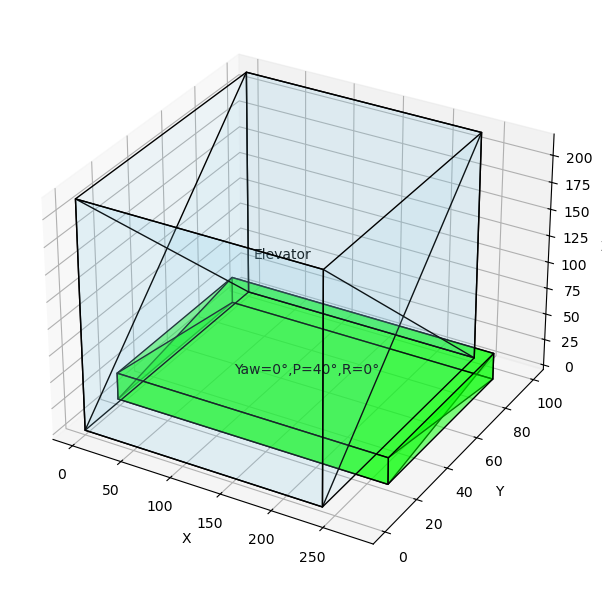

✅ Fits!
Orientation: (0, 40, 0)


In [17]:
# Test dimensions (cm)
sofa = (270, 70, 25)
elevator = (238,100,215)
door = (100,215)

fits, angles = check_and_plot_fit(sofa, elevator, door)
print("✅ Fits!" if fits else "❌ Doesn't fit.")
if angles:
    print("Orientation:", angles)

 </details> <details> <summary>4. Video Generation</summary>

# ## 🎥 Create Rotation Video
# Sweep through Yaw=0→360° and render a brief MP4.


In [ ]:
# ——— Cell 2: Video Generation Only ———

import imageio

def make_rotation_video(sofa_dims, elev_dims, door_dims,
                        axis='z', frames=36, out_path='fit.mp4'):
    """
    Sweep `axis` from 0→360° in `frames`,
    use the same draw_box & corner logic from Cell 1.
    """
    base = corners_of_box(sofa_dims) - corners_of_box(sofa_dims).mean(0)
    center = np.array(elev_dims)/2
    writer = imageio.get_writer(out_path, fps=10)

    for angle in np.linspace(0,360,frames,endpoint=False):
        rot_angles = [0,0,0]
        idx = {'z':0,'y':1,'x':2}[axis]
        rot_angles[idx] = angle
        pts = R.from_euler('zyx', rot_angles, True).apply(base) + center

        fig = plt.figure(figsize=(5,4))
        ax = fig.add_subplot(111, projection='3d')
        draw_box(ax, (0,0,0), elev_dims, 'skyblue', 0.1)
        draw_box(ax, pts.min(0), sofa_dims, 'lime', 0.5)
        ax.set_axis_off()
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1]+(3,))
        writer.append_data(img)
        plt.close(fig)

    writer.close()
    print(f"🎬 Video saved to {out_path}")

# ——— Example call ———
# make_rotation_video(
#     sofa_dims=(270,70,25),
#     elev_dims=(238,100,215),
#     door_dims=(100,215),
#     axis='z',
#     frames=36,
#     out_path='sofa_fit.mp4'
# )

In [ ]:
# Run and embed
make_rotation_video(sofa, elevator, door)